In [1]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import os
from spieks.network.converter import swap_layers
from spieks.ann.neurons import QCFS
from spieks.ann.training import test_ann, train_ann

print(f"Using pytorch {torch.__version__}")

N = 512
T = 5
DT = 0.1

MAX_HZ = 10

BS = 64
LR = 1e-3
EPOCHS = 40

# Check if CUDA is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device ({DEVICE})')

Using pytorch 2.5.1
Using device (cuda)


Seeding

In [2]:
SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Define the model

In [3]:
class MNISTModel(nn.Module):
	def __init__(self):
		super(MNISTModel, self).__init__()
		self.flatten = nn.Flatten()
		self.w1 = nn.Linear(28 * 28, 128)
		self.r1 = nn.ReLU()
		self.w2 = nn.Linear(128, 64)
		self.r2 = nn.ReLU()
		self.w3 = nn.Linear(64, 10)
		self.r3 = nn.ReLU()

		nn.init.kaiming_uniform_(self.w1.weight, nonlinearity='relu')
		nn.init.kaiming_uniform_(self.w2.weight, nonlinearity='relu')
		nn.init.kaiming_uniform_(self.w3.weight, nonlinearity='relu')

	def forward(self, x):
		x = self.flatten(x)
		x = self.w1(x)
		x = self.r1(x)
		#print('l1', x.sum(dim=1))
		x = self.w2(x)
		x = self.r2(x)
		#print('l2', x.sum(dim=1))
		x = self.w3(x)
		x = self.r3(x)
		#print('l3', x.sum(dim=1))
		return x

Train the base ANN on MNSIT

In [4]:
model_path = "tmp/models/best_mnist_model.pth"
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./tmp/data/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./tmp/data/', train=False, transform=transform, download=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)

# Check if CUDA is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device ({DEVICE})')

# Initialize model
model = MNISTModel().to(DEVICE)

# Load or train model
if os.path.exists(model_path):
	# Load model if it exists
	model.load_state_dict(torch.load(model_path, weights_only=True))
	print(f"Model loaded from file: {model_path}")
else:
	# Train from scratch otherwise
	loss_fn = nn.CrossEntropyLoss()

	# Replace all ReLU layers with QCFS to improve SNN inference
	swap_layers(model, old_layer_type=nn.ReLU, new_layer_type=QCFS, neuron_args={ "Q": 8 })
	model = train_ann(model, train_loader, test_loader, loss_fn, EPOCHS, DEVICE, save_path=model_path)

# Calculate the ANN loss and accuracy
ann_loss, ann_acc = test_ann(model, DEVICE, test_loader, loss_fn=nn.CrossEntropyLoss())
print(f"ANN Loss (CrossEntropy): {ann_loss}")
print(f"ANN Accuracy (CrossEntropy): {ann_acc}")

Using device (cuda)
Model loaded from file: tmp/models/best_mnist_model.pth
ANN Loss (CrossEntropy): 0.5433406954010328
ANN Accuracy (CrossEntropy): 0.944511217948718


Convert the ANN to an SNN

In [5]:
from spieks.network.converter import Converter
from spieks.neurons import IF
print(model)
spiking_model = Converter.convert(model, DT, model_subs={ nn.ReLU: IF })
print(spiking_model)

MNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (w1): Linear(in_features=784, out_features=128, bias=True)
  (r1): ReLU()
  (w2): Linear(in_features=128, out_features=64, bias=True)
  (r2): ReLU()
  (w3): Linear(in_features=64, out_features=10, bias=True)
  (r3): ReLU()
)
SpikingNetwork(
  (net): MNISTModel(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (w1): Linear(in_features=784, out_features=128, bias=True)
    (r1): IF(log(dt)=-1, v_r=0.0, v_th=1.0)
    (w2): Linear(in_features=128, out_features=64, bias=True)
    (r2): IF(log(dt)=-1, v_r=0.0, v_th=1.0)
    (w3): Linear(in_features=64, out_features=10, bias=True)
    (r3): IF(log(dt)=-1, v_r=0.0, v_th=1.0)
  )
)


Evaluate the SNN on classification

In [6]:
from spieks.simulator import Classifier
classifier = Classifier(spiking_model, device=DEVICE)
activations, loss, accuracy = classifier.evaluate_dataset(test_loader, duration=T)
final_accuracy = accuracy[-1]
print(f"Accuracy: {final_accuracy}")

Accuracy: 0.9378004670143127


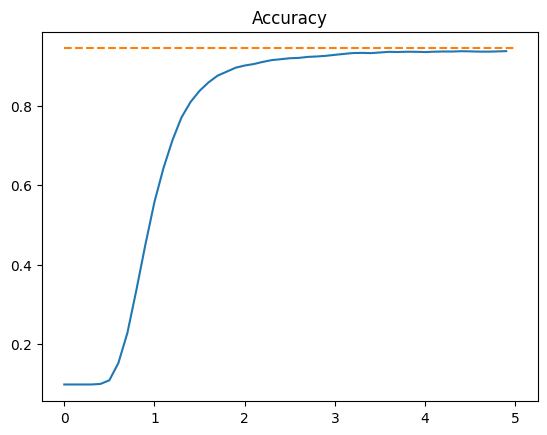

<Figure size 640x480 with 0 Axes>

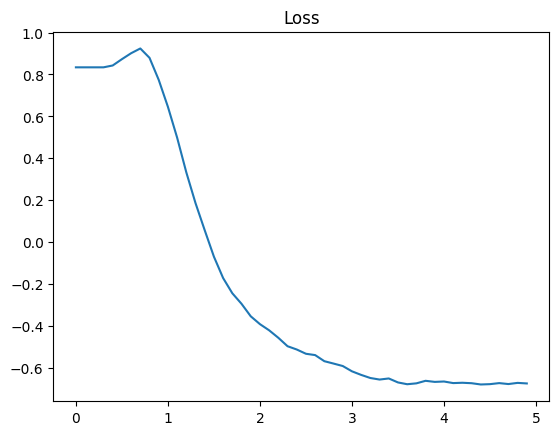

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import numpy as np

TIME = np.arange(len(accuracy)) * DT

plt.figure()
plt.title("Accuracy")
plt.hlines(ann_acc, 0, T, linestyles='--', color='C1', label='ReLU Baseline')
plt.plot(TIME, accuracy, label='IF')
plt.figure()

plt.figure()
plt.title("Loss")
plt.plot(TIME, np.log(loss), label='IF')
plt.figure()
plt.show()